![Retail](https://www.xpandretail.com/wp-content/uploads/2018/11/Screen-Shot-2018-11-26-at-2.10.07-PM.png)

<br>Content:
* [Sneak Peek into the Data](#1)
* [Analysis Datewise](#2)
* [Analysis Storewise](#3)
* [Analysis Departmentwise](#4)
* [Analysis Store Type and Year/Month Wise](#5) 
* [Analysis of MarkDown](#6)
* [Prediction on Date and Store](#7)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:

df_store = pd.read_csv("/kaggle/input/retaildataset/stores data-set.csv")
df_feature = pd.read_csv("/kaggle/input/retaildataset/Features data set.csv",parse_dates=["Date"])
df_sales = pd.read_csv("/kaggle/input/retaildataset/sales data-set.csv",parse_dates=["Date"])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/retaildataset/stores data-set.csv'

<a id="1"></a> <br>
# Sneak Peek into the Data

Lets see how the tables look and get some basic information. i.e 
* Data types
* No of Data (rows and column)
* Null Data
* few rows to understand the data

In [ ]:
print(df_store.info())
print(df_store.head())

In [ ]:
print(df_feature.info())
print(df_feature.head())

In [ ]:
print(df_sales.info())
print(df_sales.head())

looking into the data I come to the conclusion that we can group data based on the time,store,department.
Also we can check how holiday,Temperature,Fuel Price,CPI,Unemployment,Type of Store affecting sales.

<a id="2"></a> <br>
# **Analysis Datewise**

let explore data based on the timeline

* lets Merge Feature tables and sales tables based on the date 
* we will convert WeeklySales in Millions
* we will modify column as the day is holiday or not

In [ ]:
data_date = df_feature.groupby("Date").agg({"Temperature":"mean"
                                            ,"Fuel_Price":"mean"
                                            ,"IsHoliday":"sum"
                                            ,"CPI":"mean"
                                           ,"Unemployment":"mean"})
data_date = data_date.sort_index()
temp_date_data = data_date[:'2012-12-10']

data_sales_date = df_sales.groupby("Date").agg({"Weekly_Sales":"sum"})
data_sales_date.sort_index(inplace=True)
data_sales_date.Weekly_Sales = data_sales_date.Weekly_Sales/1000000
data_sales_date.Weekly_Sales = data_sales_date.Weekly_Sales.apply(int)
data = pd.merge(data_sales_date, temp_date_data, left_index=True,right_index=True, how='left')
data["IsHoliday"] = data["IsHoliday"].apply(lambda x: True if x == 45.0 else False )


In [ ]:
print(data.describe())

In [ ]:
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(15,4))
fig, ax = plt.subplots(5,1,figsize=(15,10),sharex=True) 
data["Weekly_Sales"].plot(ax=ax[0],title="Weekly Sales/sales on Holiday")
data[data.IsHoliday==True]["Weekly_Sales"].plot(marker="D",ax=ax[0],legend="Holiday Week sale")
data["Temperature"].plot(ax=ax[1], title="Temperature")
data["Fuel_Price"].plot(ax=ax[2],title="Fuel_Price")
data["CPI"].plot(ax=ax[3],title="CPI")
data["Unemployment"].plot(ax=ax[4],title="Unemployment")


* Nov- Dec shows spike in Weekly Sales.but over the year it is not increased. 
* weeks nearby holiday shows peak
* Fuel Price and Consumer Price Index shown growth over the year.
* Unemployment decreased year after year.
* Temperature is showing a random walk


In [ ]:
sns.heatmap(data.corr(),annot=True)

* Weekly sales doesnot show any high correlation with any other parameters.
* CPI and Unemployment  shows negative correlation on other hand Fuel Price show positive correlation
* Unemployment and Fuel price are also negatively correlated

In [ ]:
data_sales_month = data.groupby(data.index.month).agg({"Weekly_Sales":"sum"})
plt.figure(figsize=(10, 5))
sns.barplot(x=data_sales_month.index,y=data_sales_month.Weekly_Sales)
plt.title("Month wise Sales")
plt.xlabel("Month")
plt.ylabel("Sales")

* It could be as Enough buying during offer and holidays (Black friday Sales,Chrismas,New year) and later sales go down and then again gaining momentum in some months.
* In Nov also people show less buying can be waiting period for upcoming sales.
* whole data for Dec-2013 I guess is not available so even after spike in Dec the sales are not gone very high.

In [ ]:
data_sales_year = data.groupby(data.index.year).agg({"Weekly_Sales":"sum"})

sns.barplot(x=data_sales_year.index,y=data_sales_year.Weekly_Sales)
plt.title("Year wise Sales")
plt.xlabel("Year")
plt.ylabel("Sales")


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data["Weekly_Sales"], period=45) 

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(decomposition.trend)
plt.plot(decomposition.seasonal)
plt.plot(decomposition.resid)
plt.legend(["Trend", "Seasonal","Resid"], loc ="upper right") 

* It shows a sideway trend

<a id="3"></a> <br>
# **Analysis Storewise**

lets explore the pattern in store for weekly sales data

In [ ]:
data_Store = df_feature.groupby("Store").agg({"Temperature":"mean","Fuel_Price":"mean","IsHoliday":"sum"})

temp_store = df_sales.groupby("Store").agg({"Weekly_Sales":"sum"})
temp_store.Weekly_Sales = temp_store.Weekly_Sales/1000000
temp_store.Weekly_Sales = temp_store.Weekly_Sales.apply(int)
data_Store.set_index(np.arange(0,45),inplace=True)
# Adding the columns derived from Data_Store
df_store["temp"] = data_Store.Temperature
df_store["Fuel_Price"] = data_Store.Fuel_Price
df_store["holiday"] = data_Store.IsHoliday
df_store["Weekly_Sales"] = temp_store.Weekly_Sales

In [ ]:
df_store.describe()

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15, 4))
sns.countplot(df_store.Type,ax=ax[0])
sns.swarmplot(data = df_store,y="Size",x="Type",ax=ax[1])

sns.boxplot(data = df_store,y="Weekly_Sales",x="Type",ax=ax[2])



* Store Count is in the order of A, B and least is C 
* Size wise A store as most no of Item followed by B and than C
* Even After less Count of Store and lesser Size B has more Weekly Sales than A and C at the least.

<a id="4"></a> <br>
# **Analysis Departmentwise**

A little Invesigation on Department

In [ ]:
len(df_sales["Dept"].unique())

In [ ]:
data_Dept = df_sales.groupby("Dept").agg({"Weekly_Sales":"sum"})
data_Dept.Weekly_Sales = data_Dept.Weekly_Sales/10000
data_Dept.Weekly_Sales = data_Dept.Weekly_Sales.apply(int)
data_Dept.sort_values(by="Weekly_Sales")

In [ ]:
fig1, ax1 = plt.subplots(figsize=(15, 4))
#ordered_df = data_Dept.sort_values(by='Weekly_Sales')
plt.vlines(x=data_Dept.index, ymin=0, ymax=data_Dept['Weekly_Sales'], color='skyblue')
plt.plot(data_Dept.index,data_Dept['Weekly_Sales'], "o")
plt.title("Departmentwise Sales")
plt.ylabel("Sales")
plt.xlabel("Department")

* Here  we can see department 1-15 as well as 90-95 has shown  higher weekly sales.
* some department as 38,40,72 has shown higher weekly sales.

<a id="5"></a> <br>
# Analysis Store Type and Year/Month Wise 

In [ ]:
sales_date_store = df_sales.groupby(["Date","Store"]).agg({"Weekly_Sales":"sum"})
sales_date_store.sort_index(inplace=True)
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales/10000
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales.apply(int)
data_table = pd.merge(df_feature,sales_date_store ,  how='left', on=["Date","Store"])
data_table = pd.merge(data_table,df_store[["Store","Type"]] ,  how='left', on=["Store"])
data_table.head(20)
data_train = data_table[data_table.Weekly_Sales.notnull()]
data_test = data_table[data_table.Weekly_Sales.isnull()]

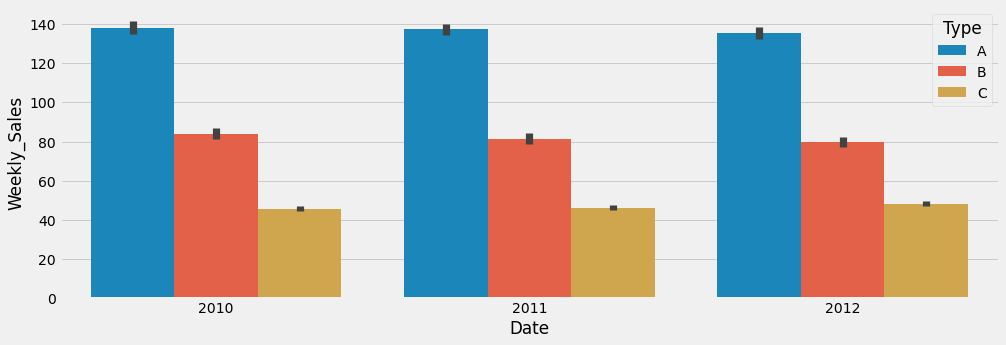

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x=data_train.Date.dt.year, y=data_train.Weekly_Sales,hue=data_train.Type)

* Store Type A & B has shown slight decrease year on basis in sales.
* Store C has shown a slight increase in sales.

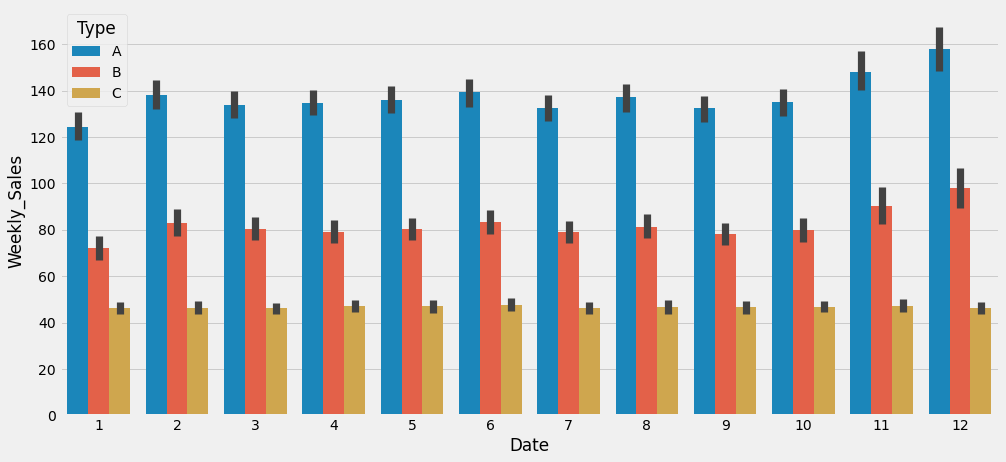

In [22]:
plt.figure(figsize=(15, 7))
sns.barplot(x=data_train.Date.dt.month, y=data_train.Weekly_Sales,hue=data_train.Type)

* Type A & B store show spike in Nov Dec mostly due to holiday whereas jan has shown decrease in sale.
* Type C is consistent over every month and doesnot show much deviation.
   

<a id="6"></a> <br>
# Analysis of MarkDown

Text(0.5, 0, 'Date')

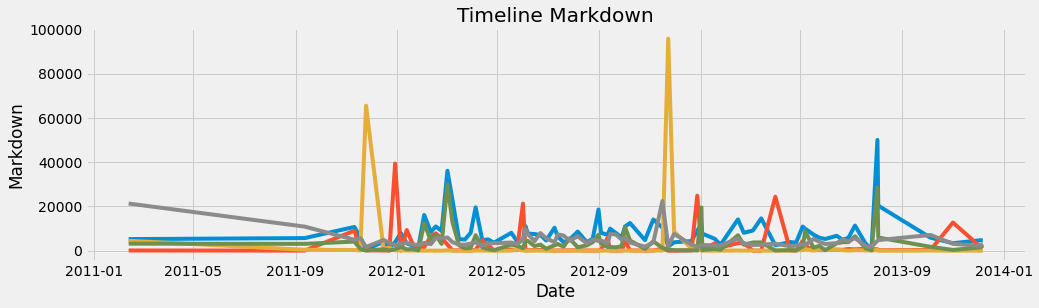

In [23]:
plt.figure(figsize=(15,4))
train_markdown = data_table[data_table.MarkDown2.notnull()]
train_markdown = train_markdown.groupby("Date").agg({"MarkDown1":"mean","MarkDown2":"mean","MarkDown3":"mean","MarkDown4":"mean","MarkDown5":"mean"})


plt.plot(train_markdown.index,train_markdown.MarkDown1)
plt.plot(train_markdown.index,train_markdown.MarkDown2)
plt.plot(train_markdown.index,train_markdown.MarkDown3)
plt.plot(train_markdown.index,train_markdown.MarkDown4)
plt.plot(train_markdown.index,train_markdown.MarkDown5)
plt.title("Timeline Markdown")
plt.ylabel("Markdown")
plt.xlabel("Date")

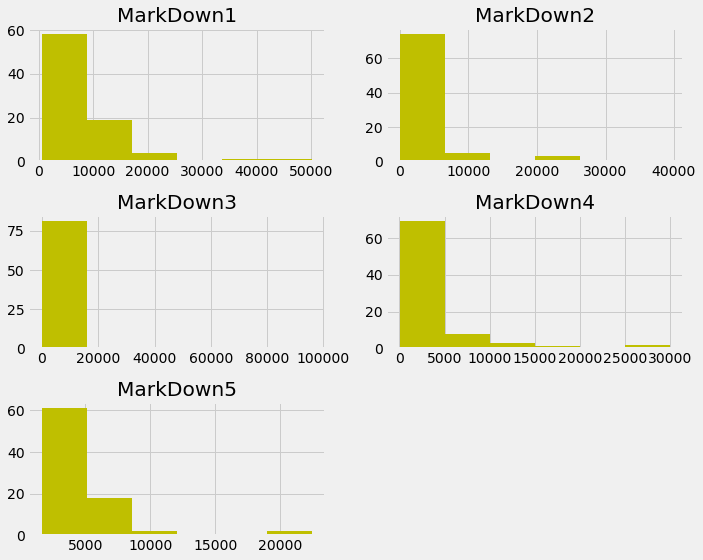

In [24]:
train_markdown.hist(figsize=(10,8),bins=6,color='Y')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Markdown')

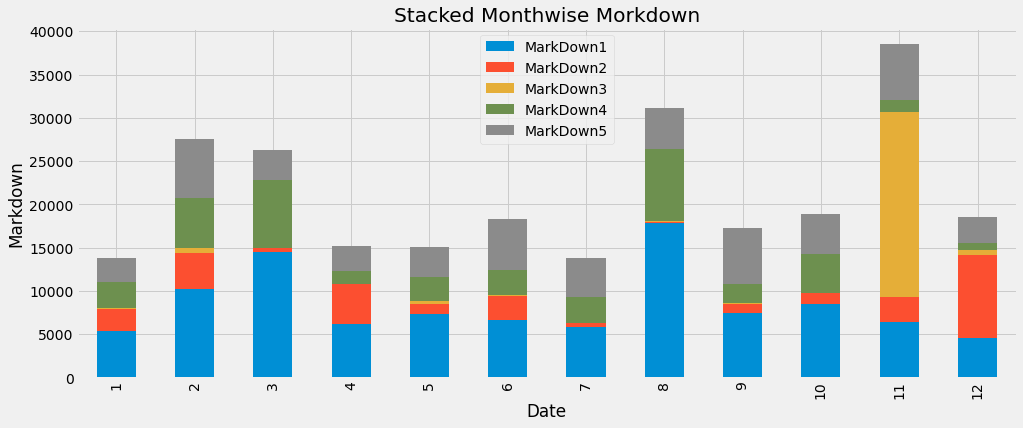

In [25]:
train_markdown_month = train_markdown.groupby(train_markdown.index.month).agg({"MarkDown1":"mean","MarkDown2":"mean","MarkDown3":"mean","MarkDown4":"mean","MarkDown5":"mean"})

train_markdown_month.plot(kind='bar', stacked=True,figsize=(15,6))
plt.title("Stacked Monthwise Morkdown")
plt.ylabel("Markdown")

Text(0, 0.5, 'Markdown')

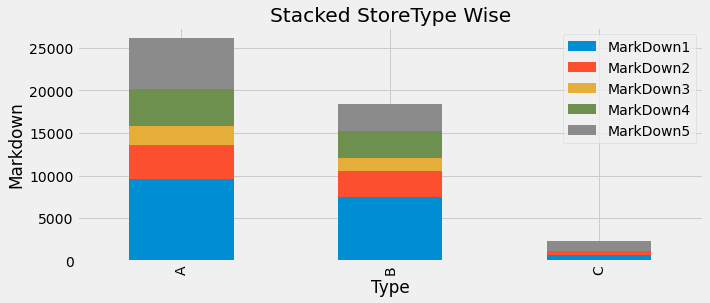

In [26]:
train_markdown_1 = data_table[data_table.MarkDown2.notnull()]
train_markdown_type = train_markdown_1.groupby("Type").agg({"MarkDown1":"mean","MarkDown2":"mean","MarkDown3":"mean","MarkDown4":"mean","MarkDown5":"mean"})

train_markdown_type.plot(kind='bar', stacked=True,figsize=(10,4))
plt.title("Stacked StoreType Wise")
plt.ylabel("Markdown")

<a id="7"></a> <br>
# **Prediction on Date and Store**

In [27]:

from fancyimpute import IterativeImputer
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

**Clean up and preprocessing**

In [28]:
def createdummies(data,cols):
    for col in cols:
        one_hot = pd.get_dummies(data[col],prefix=col)
        data = data.join(one_hot)
        data.drop(col,axis = 1,inplace=True)
    
    return data
        

In [29]:

# imputing the missing value
itt = IterativeImputer()
df = itt.fit_transform(data_table[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]) 
data_table.MarkDown1 = df[:,0]
data_table.MarkDown2 = df[:,1]
data_table.MarkDown3 = df[:,2]
data_table.MarkDown4 = df[:,3]
data_table.MarkDown5 = df[:,4]

data_table['CPI'].fillna((data_table['CPI'].mean()), inplace=True)
data_table['Unemployment'].fillna((data_table['Unemployment'].mean()), inplace=True)
data_table['IsHoliday'] = data_table['IsHoliday'].map({True:0,False:1})

#create new column
data_table["Month"] = data_table.Date.dt.month
data_table["Year"] = data_table.Date.dt.year
data_table["WeekofYear"] = data_table.Date.dt.weekofyear
data_table.drop(['Date'],axis=1,inplace=True)

#create dummies out of categorical column
data_table = createdummies(data_table,["Type","Month","Year","WeekofYear"])



In [30]:
data_table.columns

Index(['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Type_A', 'Type_B', 'Type_C', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'WeekofYear_1', 'WeekofYear_2',
       'WeekofYear_3', 'WeekofYear_4', 'WeekofYear_5', 'WeekofYear_6',
       'WeekofYear_7', 'WeekofYear_8', 'WeekofYear_9', 'WeekofYear_10',
       'WeekofYear_11', 'WeekofYear_12', 'WeekofYear_13', 'WeekofYear_14',
       'WeekofYear_15', 'WeekofYear_16', 'WeekofYear_17', 'WeekofYear_18',
       'WeekofYear_19', 'WeekofYear_20', 'WeekofYear_21', 'WeekofYear_22',
       'WeekofYear_23', 'WeekofYear_24', 'WeekofYear_25', 'WeekofYear_26',
       'WeekofYear_27', 'WeekofYear_28', 'WeekofYear_29', 'WeekofYear_30',
       'WeekofYear_31', 'WeekofYear_

**Data Split**

In [31]:
data_train = data_table[data_table.Weekly_Sales.notnull()]
data_test = data_table[data_table.Weekly_Sales.isnull()]
X = data_train.drop('Weekly_Sales', axis=1)
y = data_train['Weekly_Sales']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Basic Model Creation**

In [32]:



classifiers = [
    LinearRegression(),
    ElasticNet(),
    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=3, coef0=2.5),
    Lasso(alpha =16, random_state=100),
    ElasticNet(alpha=0.8),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(), 
    LinearSVR(), 
    NuSVR(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
    ]

name = []
score = []
models = []
rmse = []
i = 0
for classifier in classifiers:
    classifier.fit(X_train, y_train)   
    name.append(type(classifier).__name__)
    score.append(classifier.score(X_test, y_test))
    models.append(classifier)
    rmse.append(np.sqrt(mean_squared_error(classifier.predict(X_test), y_test)))


**Comparing Model Performance**

In [33]:
df_score = pd.DataFrame(list(zip(name,rmse, score, models)),columns=['name','rmse','score',"model"])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['score'],inplace=True)
df_score

,rmse,score,model
name,,,
LinearSVR,95.204359,-1.837139,LinearSVR()
KernelRidge,64.099789,-0.286116,"KernelRidge(alpha=0.6, coef0=2.5, kernel='poly..."
NuSVR,53.806148,0.093786,NuSVR()
SVR,53.745821,0.095817,SVR()
Lasso,51.595504,0.166721,"Lasso(alpha=16, random_state=100)"
ElasticNet,45.021246,0.365543,ElasticNet()
ElasticNet,44.304403,0.385587,ElasticNet(alpha=0.8)
LinearRegression,38.749155,0.530007,LinearRegression()
RidgeCV,38.748732,0.530017,"RidgeCV(alphas=array([0.001, 0.01 , 0.1 , 1. ..."


**Prediction**

In [34]:
model = df_score.loc["XGBRegressor","model"]
data_test.drop(['Weekly_Sales'],axis=1,inplace=True)
predict = model.predict(data_test)
predict

array([160.37555 , 161.73837 , 150.30173 , ...,  78.426575,  76.15676 ,
        74.68166 ], dtype=float32)

# Work In Progress

**Thank you for Reading, Please Upvote ,Comment and Follow for motivating me for more such work**

![Thanks](https://www.access2interpreters.com/wp-content/uploads/2016/01/thank-you.jpg)